In [1]:
import xgboost as xgb
import pandas as pd 
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
import os
import xgboost as xgb
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [2]:
## DO NOT USE THIS DATASET IMPROTED CSV FILE, I CUT IT ONLY UP TO AROUND 100000 FOR VARIABLE FEATURES CREATION ONLY

In [3]:
df0=pd.read_csv('training_feature_creation_only.csv')

In [4]:
1- df0.count()/len(df0)

srch_id                        0.000000
site_id                        0.000000
visitor_location_country_id    0.000000
visitor_hist_starrating        0.945515
visitor_hist_adr_usd           0.945340
prop_country_id                0.000000
prop_id                        0.000000
prop_starrating                0.000000
prop_review_score              0.001339
prop_brand_bool                0.000000
prop_location_score1           0.000000
prop_location_score2           0.215844
prop_log_historical_price      0.000000
position                       0.000000
price_usd                      0.000000
promotion_flag                 0.000000
srch_destination_id            0.000000
srch_length_of_stay            0.000000
srch_booking_window            0.000000
srch_adults_count              0.000000
srch_children_count            0.000000
srch_room_count                0.000000
srch_saturday_night_bool       0.000000
srch_query_affinity_score      0.937565
orig_destination_distance      0.322312


In [5]:
df0.head(4)

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,click_bool,gross_bookings_usd,booking_bool
0,1,12,187,NaN,NaN,219,893,3,3.5,1,...,4,0,1,1,NaN,NaN,1,0,NaN,0
1,1,12,187,NaN,NaN,219,10404,4,4.0,1,...,4,0,1,1,NaN,NaN,1,0,NaN,0
2,1,12,187,NaN,NaN,219,21315,3,4.5,1,...,4,0,1,1,NaN,NaN,1,0,NaN,0
3,1,12,187,NaN,NaN,219,27348,2,4.0,1,...,4,0,1,1,NaN,NaN,1,0,NaN,0


In [6]:
# Build up target feature Click = 1, book and click = 2 then no book no click = 0

In [7]:
conditions = [
    df0['booking_bool'].eq(0) & df0['click_bool'].eq(1),
     df0['booking_bool'].eq(1) & df0['click_bool'].eq(1),
     df0['booking_bool'].eq(0) & df0['click_bool'].eq(0),]
choices = ['click','book','C']
df0['book_click'] = np.select(conditions, choices, default=0)

In [8]:
df1=df0.copy()

In [9]:
df1.visitor_hist_starrating.fillna(-1, inplace=True)
df1.visitor_hist_adr_usd.fillna(-1, inplace=True)
df1.gross_bookings_usd.fillna(-1, inplace=True)
df1.srch_query_affinity_score.fillna(-1, inplace=True)
df1.orig_destination_distance.fillna(0, inplace=True)

In [10]:
df1['prop_review_score']=df1.groupby('prop_starrating')['prop_review_score'].transform(lambda x: x.fillna(x.mean()))
df1['prop_location_score2']=df1.groupby('prop_location_score1')['prop_location_score2'].transform(lambda x: x.fillna(x.mean()))


In [11]:
# round up to get review score same as 'prop_starrating' in same scale
df1['prop_review_score']= ((df1['prop_review_score']*10**0+0.5)/10**0).apply(np.floor,1)

In [12]:
# there are some prop_location_score2 dont have group in score 1 then, imputed 2 remainder values with average
df1['prop_location_score2'].fillna(value=df1['prop_location_score2'].mean(), inplace=True)

In [13]:
1- df1.count()/len(df1)

srch_id                        0.0
site_id                        0.0
visitor_location_country_id    0.0
visitor_hist_starrating        0.0
visitor_hist_adr_usd           0.0
prop_country_id                0.0
prop_id                        0.0
prop_starrating                0.0
prop_review_score              0.0
prop_brand_bool                0.0
prop_location_score1           0.0
prop_location_score2           0.0
prop_log_historical_price      0.0
position                       0.0
price_usd                      0.0
promotion_flag                 0.0
srch_destination_id            0.0
srch_length_of_stay            0.0
srch_booking_window            0.0
srch_adults_count              0.0
srch_children_count            0.0
srch_room_count                0.0
srch_saturday_night_bool       0.0
srch_query_affinity_score      0.0
orig_destination_distance      0.0
random_bool                    0.0
click_bool                     0.0
gross_bookings_usd             0.0
booking_bool        

### So now 2nd task data visulization

### So now 3th task feature creation

y: book_click ( did it before)
    
x:
Bagus:
(1) sameloc : We want to know whether the user is in the same location as the hotel he/she searches or not.If im from indonesia and search for a hotel in Spain, the probability of me clicking a hotel maybe higher if I already arrived in Spain

(2) pricepernight : We want calculate price for a night based on length of stay per room

(3) pricediffmean : We compare the price of a hotel with other hotel in each search
-> I modify bit, we can groupby prop_starrating, to see if hotel A and B in with same start (for ex 3 start) , how much price different 

Quin

(4) diff_displayed_vs_per_night: We want to calculate price diff for a night compared to display price ( if tax and other fee take large proportion over price displayed or not)

(5) diff_star_vs_review: We want to check whether star hotel deserve to which customer review

(6) diff_score1_its_mean_country= the proportion of Average location score on evarage per country located rating and its score 1, groupby prop_country_id

(7) diff_score2_its_mean_country= the proportion o Average location score on evarage per country located rating and its score 2, groupby prop_country_id
 
(8) diff_score1_score2: check assessement of location score 



In [14]:
#1 
df1['sameloc']=0
df1.loc[df1.prop_country_id==df1.visitor_location_country_id,'sameloc']=1

In [15]:
#2 
df1['pricepernight']=df1.price_usd/(df1.srch_length_of_stay*(df1['srch_room_count']))

In [16]:
#3
a = df1['pricepernight'].groupby(df1['prop_starrating']).mean().to_dict()
#Create new collumn to get the average price per start category, should remove it when used as feature since it is same as star rating
df1['average_price_per_star']=df1['prop_starrating'].map(a)
# keep it
df1['diff_average_price_per_start'] = abs(df1['pricepernight']-df1['average_price_per_star'])

In [17]:
df1.head()

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,orig_destination_distance,random_bool,click_bool,gross_bookings_usd,booking_bool,book_click,sameloc,pricepernight,average_price_per_star,diff_average_price_per_start
0,1,12,187,-1.0,-1.0,219,893,3,4.0,1,...,0.0,1,0,-1.0,0,C,0,104.77,83.268482,21.501518
1,1,12,187,-1.0,-1.0,219,10404,4,4.0,1,...,0.0,1,0,-1.0,0,C,0,170.74,118.113250,52.626750
2,1,12,187,-1.0,-1.0,219,21315,3,5.0,1,...,0.0,1,0,-1.0,0,C,0,179.80,83.268482,96.531518
3,1,12,187,-1.0,-1.0,219,27348,2,4.0,1,...,0.0,1,0,-1.0,0,C,0,602.77,69.353807,533.416193
4,1,12,187,-1.0,-1.0,219,29604,4,4.0,1,...,0.0,1,0,-1.0,0,C,0,143.58,118.113250,25.466750


In [18]:
# 4
df1['diff_displayed_vs_per_night'] = (abs(df1['pricepernight']-df1['price_usd']))/df1['price_usd']

In [19]:
#5 

In [20]:
df1['diff_star_vs_review'] = (abs(df1['prop_starrating']-df1['prop_review_score']))

In [21]:
#6

In [22]:
b = df1['prop_location_score1'].groupby(df1['prop_country_id']).mean().to_dict()
#Create new collumn to get the average price per start category, should remove it when used as feature since it is same as star rating
df1['mean_score1']=df1['prop_country_id'].map(b)
# keep it
df1['diff_score1_its_mean_country'] = abs(df1['mean_score1']-df1['prop_location_score1'])/df1['prop_location_score1']

In [23]:
#7
c = df1['prop_location_score2'].groupby(df1['prop_country_id']).mean().to_dict()
#Create new collumn to get the average price per start category, should remove it when used as feature since it is same as star rating
df1['mean_score2']=df1['prop_country_id'].map(c)
# keep it
df1['diff_score2_its_mean_country'] = abs(df1['mean_score2']-df1['prop_location_score2'])/df1['prop_location_score2']

In [24]:
#8 
df1['diff_score1_score2'] = abs(df1['prop_location_score1']-df1['prop_location_score2'])

In [25]:
1- df1.count()/len(df1)

srch_id                         0.0
site_id                         0.0
visitor_location_country_id     0.0
visitor_hist_starrating         0.0
visitor_hist_adr_usd            0.0
prop_country_id                 0.0
prop_id                         0.0
prop_starrating                 0.0
prop_review_score               0.0
prop_brand_bool                 0.0
prop_location_score1            0.0
prop_location_score2            0.0
prop_log_historical_price       0.0
position                        0.0
price_usd                       0.0
promotion_flag                  0.0
srch_destination_id             0.0
srch_length_of_stay             0.0
srch_booking_window             0.0
srch_adults_count               0.0
srch_children_count             0.0
srch_room_count                 0.0
srch_saturday_night_bool        0.0
srch_query_affinity_score       0.0
orig_destination_distance       0.0
random_bool                     0.0
click_bool                      0.0
gross_bookings_usd          

In [26]:
df1.tail(10)

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,pricepernight,average_price_per_star,diff_average_price_per_start,diff_displayed_vs_per_night,diff_star_vs_review,mean_score1,diff_score1_its_mean_country,mean_score2,diff_score2_its_mean_country,diff_score1_score2
108295,7244,14,100,-1.0,-1.0,100,75972,3,4.0,1,...,75.680,83.268482,7.588482,0.5,1.0,2.887686,0.331554,0.128359,0.389350,4.1098
108296,7244,14,100,-1.0,-1.0,100,80545,4,4.0,1,...,208.625,118.113250,90.511750,0.5,0.0,2.887686,0.276269,0.128359,0.263576,3.8157
108297,7244,14,100,-1.0,-1.0,100,87652,4,4.0,1,...,161.320,118.113250,43.206750,0.5,0.0,2.887686,0.206680,0.128359,2.742234,3.6057
108298,7244,14,100,-1.0,-1.0,100,94988,2,4.0,1,...,59.250,69.353807,10.103807,0.5,2.0,2.887686,0.174947,0.128359,4.217830,3.4754
108299,7244,14,100,-1.0,-1.0,100,103583,3,5.0,1,...,64.730,83.268482,18.538482,0.5,2.0,2.887686,0.265220,0.128359,8.651024,3.9167
108300,7244,14,100,-1.0,-1.0,100,118206,5,5.0,1,...,190.200,170.539134,19.660866,0.5,0.0,2.887686,0.221648,0.128359,3.617216,3.6822
108301,7244,14,100,-1.0,-1.0,100,119794,4,4.0,1,...,190.200,118.113250,72.086750,0.5,0.0,2.887686,0.317332,0.128359,0.312855,4.0432
108302,7244,14,100,-1.0,-1.0,100,123898,5,5.0,1,...,230.530,170.539134,59.990866,0.5,0.0,2.887686,0.305845,0.128359,0.378709,3.9534
108303,7244,14,100,-1.0,-1.0,100,128272,5,5.0,0,...,224.060,170.539134,53.520866,0.5,0.0,2.887686,0.206680,0.128359,3.754023,3.6130
108304,7244,14,100,-1.0,-1.0,100,132210,4,4.0,1,...,146.385,118.113250,28.271750,0.5,0.0,2.887686,0.351082,0.128359,0.471775,4.2070


In [27]:
df1.nunique()

srch_id                          4365
site_id                            31
visitor_location_country_id        97
visitor_hist_starrating           118
visitor_hist_adr_usd              251
prop_country_id                   103
prop_id                         43355
prop_starrating                     6
prop_review_score                   6
prop_brand_bool                     2
prop_location_score1              334
prop_location_score2             6649
prop_log_historical_price         310
position                           39
price_usd                       20437
promotion_flag                      2
srch_destination_id              2185
srch_length_of_stay                21
srch_booking_window               263
srch_adults_count                   9
srch_children_count                 6
srch_room_count                     7
srch_saturday_night_bool            2
srch_query_affinity_score        6612
orig_destination_distance       53270
random_bool                         2
click_bool  

# ALGORITHM 

In [28]:
# round all upto 3 digits
df1.round(decimals=3)

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,pricepernight,average_price_per_star,diff_average_price_per_start,diff_displayed_vs_per_night,diff_star_vs_review,mean_score1,diff_score1_its_mean_country,mean_score2,diff_score2_its_mean_country,diff_score1_score2
0,1,12,187,-1.0,-1.0,219,893,3,4.0,1,...,104.770,83.268,21.502,0.0,1.0,2.604,0.080,0.118,1.688,2.786
1,1,12,187,-1.0,-1.0,219,10404,4,4.0,1,...,170.740,118.113,52.627,0.0,0.0,2.604,0.183,0.118,6.900,2.185
2,1,12,187,-1.0,-1.0,219,21315,3,5.0,1,...,179.800,83.268,96.532,0.0,2.0,2.604,0.183,0.118,3.805,2.176
3,1,12,187,-1.0,-1.0,219,27348,2,4.0,1,...,602.770,69.354,533.416,0.0,2.0,2.604,0.080,0.118,8.417,2.818
4,1,12,187,-1.0,-1.0,219,29604,4,4.0,1,...,143.580,118.113,25.467,0.0,0.0,2.604,0.014,0.118,0.051,2.516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108300,7244,14,100,-1.0,-1.0,100,118206,5,5.0,1,...,190.200,170.539,19.661,0.5,0.0,2.888,0.222,0.128,3.617,3.682
108301,7244,14,100,-1.0,-1.0,100,119794,4,4.0,1,...,190.200,118.113,72.087,0.5,0.0,2.888,0.317,0.128,0.313,4.043
108302,7244,14,100,-1.0,-1.0,100,123898,5,5.0,1,...,230.530,170.539,59.991,0.5,0.0,2.888,0.306,0.128,0.379,3.953
108303,7244,14,100,-1.0,-1.0,100,128272,5,5.0,0,...,224.060,170.539,53.521,0.5,0.0,2.888,0.207,0.128,3.754,3.613


In [29]:
# replace all inf value with NAN and found it happening in diff_score1_its_mean_country and diff_score2_its_mean_country 
# imputed small missing value with its mean of collumns
df1.replace([np.inf, -np.inf], np.nan, inplace=True)
df1['diff_score1_its_mean_country']=df1['diff_score1_its_mean_country'].transform(lambda x: x.fillna(x.mean()))
df1['diff_score2_its_mean_country']=df1['diff_score2_its_mean_country'].transform(lambda x: x.fillna(x.mean()))

In [30]:
# revert y vale into numerical value
# drop non importance in X 
conditions = [
    df1['booking_bool'].eq(0) & df1['click_bool'].eq(1),
     df1['booking_bool'].eq(1) & df1['click_bool'].eq(1),
     df1['booking_bool'].eq(0) & df1['click_bool'].eq(0),]
choices = [1,2,0]
df1['book_click_y'] = np.select(conditions, choices, default=0)
y= df1['book_click_y'].copy()

In [31]:
X= df1.drop(['booking_bool', 'click_bool', 'book_click', 'book_click_y'], axis =1).copy()

In [32]:
# train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [33]:
# test accuracy 
clf_dt=DecisionTreeClassifier(random_state=42).fit(X_train,y_train)
y_pred =clf_dt.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))

Accuracy: 0.96


In [34]:
# Tuning and optimal hyperparameters
# find suitable alphas
path=clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas=path.ccp_alphas
# we exclude the max value of alpha because it would prune all leaves and only roots instead
ccp_alphas=ccp_alphas[:-1]
#Create array that we put all decision tree value in this
clf_dts = []
# create loop so that the decision tree can run with array of ccp_alphas
for i in ccp_alphas:
    clf_dt= DecisionTreeClassifier(random_state=0, ccp_alpha=i)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

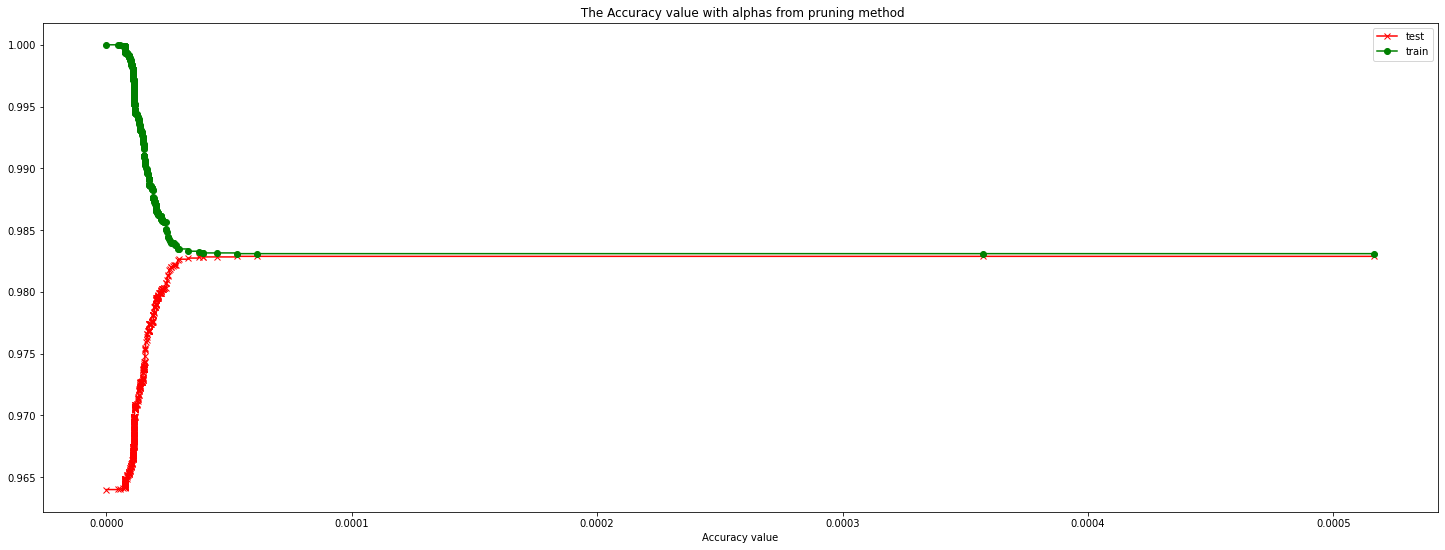

In [35]:
# then we can plot the tree by training test data with testing data as alpha 
train=[clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test=[clf_dt.score(X_test, y_test) for clf_dt in clf_dts]
# in this graph, we find the optimal alpha before ploting tree
fig, ax = plt.subplots(figsize=(25,9))
ax.set_xlabel('alphas value')
ax.set_xlabel('Accuracy value')
ax.set_title(' The Accuracy value with alphas from pruning method')
ax.plot(ccp_alphas, test, marker='x', label="test", color = 'red', drawstyle="steps-post")
ax.plot(ccp_alphas, train, marker='o', label='train', color = 'green', drawstyle="steps-post")
ax.legend()
plt.show()

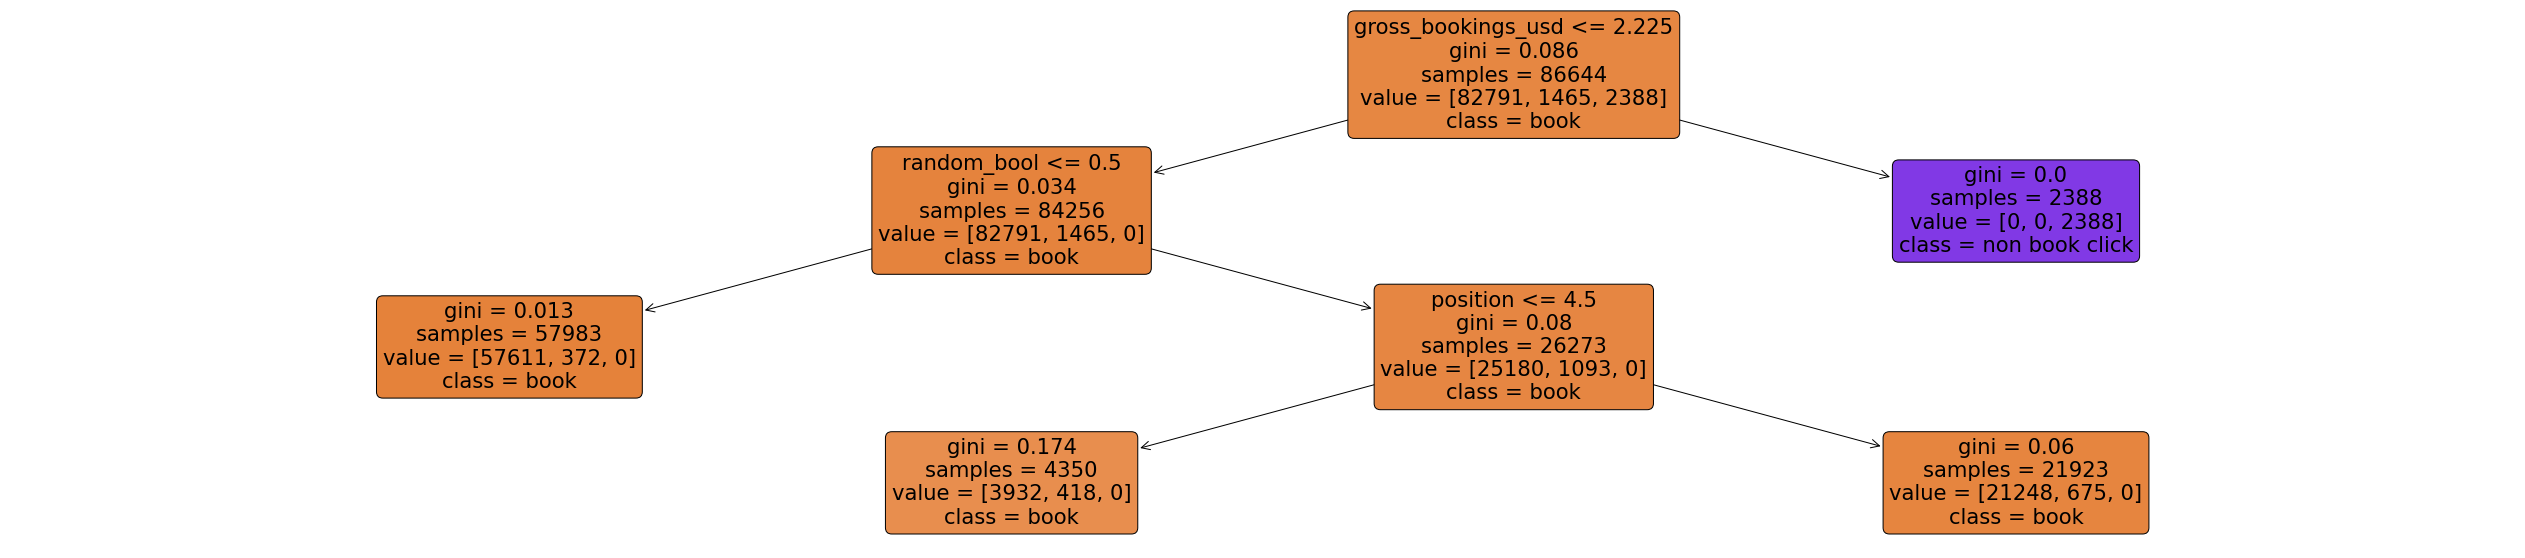

In [40]:
# check after optimial alpha


# good alpha 0.00008
clf_dt_alpha= DecisionTreeClassifier(random_state=0, ccp_alpha=0.00008).fit(X_train, y_train)
plt.figure(figsize=(45,10))
plot_tree(clf_dt_alpha,filled=True,rounded=True,class_names=["book","click","non book click"]
         ,feature_names=X.columns);

In [41]:
# recheck accuracy 

clf_dt=DecisionTreeClassifier(random_state=42, ccp_alpha=0.00008).fit(X_train,y_train)
y_pred =clf_dt.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))

Accuracy: 0.98


<AxesSubplot:xlabel='tree'>

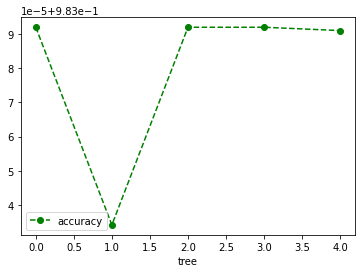

In [43]:
# cost complexity pruning and cross validation
clf_dt_alpha_improve= DecisionTreeClassifier(random_state=42, ccp_alpha=0.00008)
scores=cross_val_score(clf_dt_alpha_improve,X_train, y_train,cv=5)
df_alpha=pd.DataFrame(data={'tree':range(5),'accuracy':scores})
# then we plot the graph with alpha= 0.00019 using different train/test data . As resulted, we have different accuracies
# this is alpha is sensitive to dataset hence we use different different train/test data 
df_alpha.plot(x='tree',y='accuracy',marker='o',linestyle='--', color='green')
# As result, we find 5 diffent accuracy if we used same alpha for different train/test data set

<AxesSubplot:xlabel='alpha'>

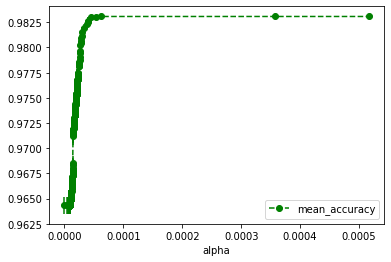

In [44]:
# create array to store the result of optimal alphas pf each fold during cross validation
optimal_alpha=[]
# use the loop to store the optimal alphas after running 5 fold cross validation
for i in ccp_alphas:
    clf_dt= DecisionTreeClassifier(random_state=0, ccp_alpha=i)
    scores= cross_val_score(clf_dt,X_train, y_train,cv=5 )
    optimal_alpha.append([i,np.mean(scores),np.std(scores)])
# plot the graph of mean and standard devisation of each score in each alpha
# create the data frame with relavent collumns
alpha_plot=pd.DataFrame(optimal_alpha,columns=['alpha','mean_accuracy','std'])
alpha_plot.plot(x='alpha',y= 'mean_accuracy',yerr='std',marker='o',linestyle='--', color='green')
# In the graph, the optimal alpha seem not 0.008

In [55]:
# Find the optimal alpha by looking at data frame with specific condiction
alpha_plot[(alpha_plot['alpha']>0.00008)&(alpha_plot['alpha']<=0.0001)]
alpha_plot
# we found alpha =  deliver highest accuracy 

,alpha,mean_accuracy,std
0,0.000000,0.964314,0.000838
1,0.000005,0.964314,0.000838
2,0.000006,0.964314,0.000838
3,0.000007,0.964314,0.000838
4,0.000007,0.964371,0.000858
...,...,...,...
539,0.000045,0.982999,0.000069
540,0.000053,0.983022,0.000067
541,0.000061,0.983080,0.000023
542,0.000357,0.983080,0.000023


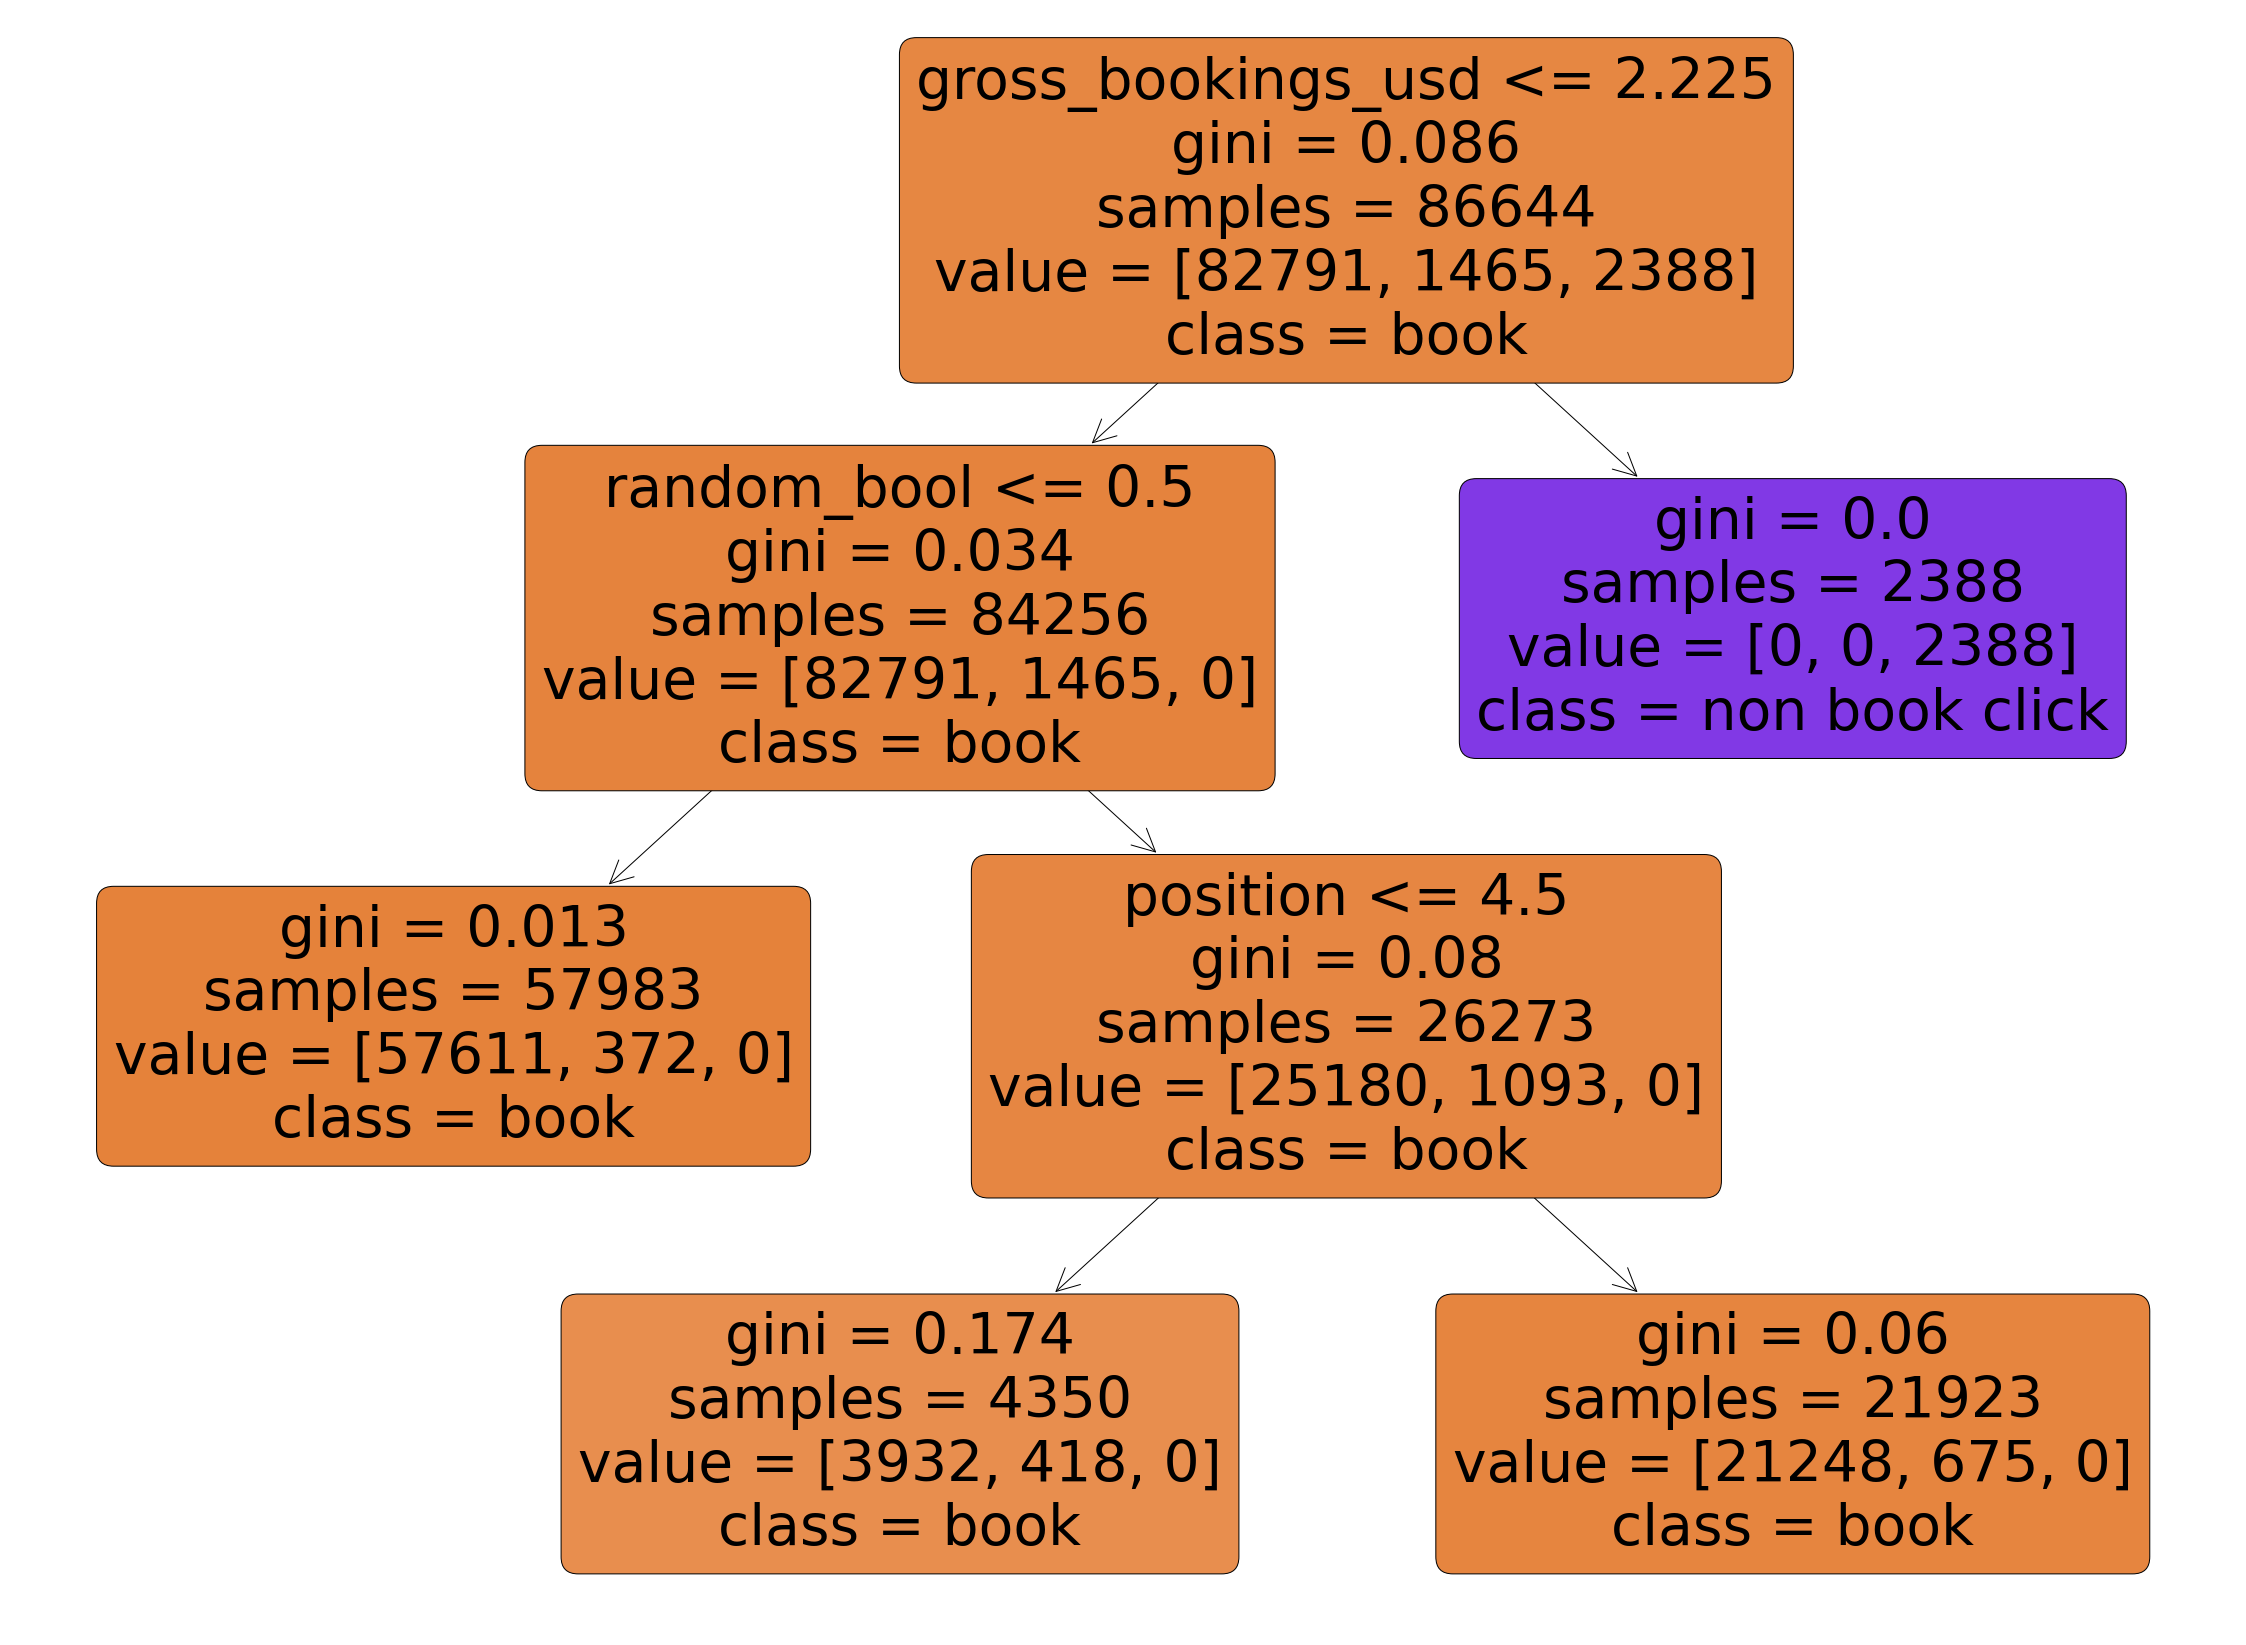

In [49]:
# optimal alpha is 0.006
clf_dt_alpha= DecisionTreeClassifier(random_state=0, ccp_alpha=0.000087).fit(X_train, y_train)
plt.figure(figsize=(40,30))
plot_tree(clf_dt_alpha,filled=True,rounded=True,class_names=["book","click","non book click"]
         ,feature_names=X.columns);
# The final tree with optimal alpha based on mean accuracy